In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

PROJECT_DIR = ".."
DATA_DIR = f"{PROJECT_DIR}/data/raw"

# Fine tuning params
MAX_DEPTH = 5
MAX_SAMPLE_SPLIT = 2
MIN_SAMPLE_LEAF = 1
CRITERION = "gini" # gini or entropy

In [14]:
data = pd.read_csv(f"{DATA_DIR}/irrigation.csv")
data.head()

,Soil Moisture,Temperature,Air Humidity,Pump Data
0,683.802906,29.184908,71.789699,0
1,408.571567,33.707205,77.977391,1
2,659.092074,24.760311,60.776282,1
3,842.929764,32.738515,59.323543,0
4,414.199320,25.692744,66.624914,1


In [15]:
print(data.info())
print(data.describe())
print(data['Pump Data'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Soil Moisture  3000 non-null   float64
 1   Temperature    3000 non-null   float64
 2   Air Humidity   3000 non-null   float64
 3   Pump Data      3000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 93.9 KB
None
       Soil Moisture  Temperature  Air Humidity    Pump Data
count    3000.000000  3000.000000   3000.000000  3000.000000
mean      662.419754    28.443043     59.387209     0.523000
std       187.936297     6.018565     12.428161     0.499554
min       314.511016    18.002132     38.000201     0.000000
25%       501.362575    23.320750     48.661993     0.000000
50%       666.578554    28.361854     58.975423     1.000000
75%       821.867423    33.595989     70.138397     1.000000
max       984.828010    38.992770     81.267407     1.000000
Pump Data
1    1569
0    

In [16]:
X = data[["Soil Moisture", "Temperature", "Air Humidity"]]
y = data["Pump Data"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = DecisionTreeClassifier(
    criterion=CRITERION,   
     splitter="best",         
    max_depth=None,          
    min_samples_split=MAX_SAMPLE_SPLIT,     
    min_samples_leaf=MIN_SAMPLE_LEAF,      
    min_weight_fraction_leaf=0.0,
    max_features=None,       
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None
)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
# Start timing
import time
training_start_time = time.time()
print("Starting model training...")

Starting model training...


In [19]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9983333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      1.00      1.00       314

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Confusion Matrix:
 [[286   0]
 [  1 313]]


In [20]:
# End timing
training_end_time = time.time()
print(f"Model training and evaluation completed in {training_end_time - training_start_time:.2f} seconds")

Model training and evaluation completed in 0.03 seconds


In [21]:
# Calculate comprehensive metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

# Calculate individual metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Pump OFF", "Pump ON"]))

Accuracy: 0.9983
F1 Score: 0.9984
Precision: 1.0000
Recall: 0.9968

Detailed Classification Report:
              precision    recall  f1-score   support

    Pump OFF       1.00      1.00      1.00       286
     Pump ON       1.00      1.00      1.00       314

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [22]:
sample = [[700, 30, 65]]  # Soil moisture, Temp, Humidity
pred = clf.predict(sample)
print("Pump ON" if pred[0] == 1 else "Pump OFF")

Pump OFF


/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


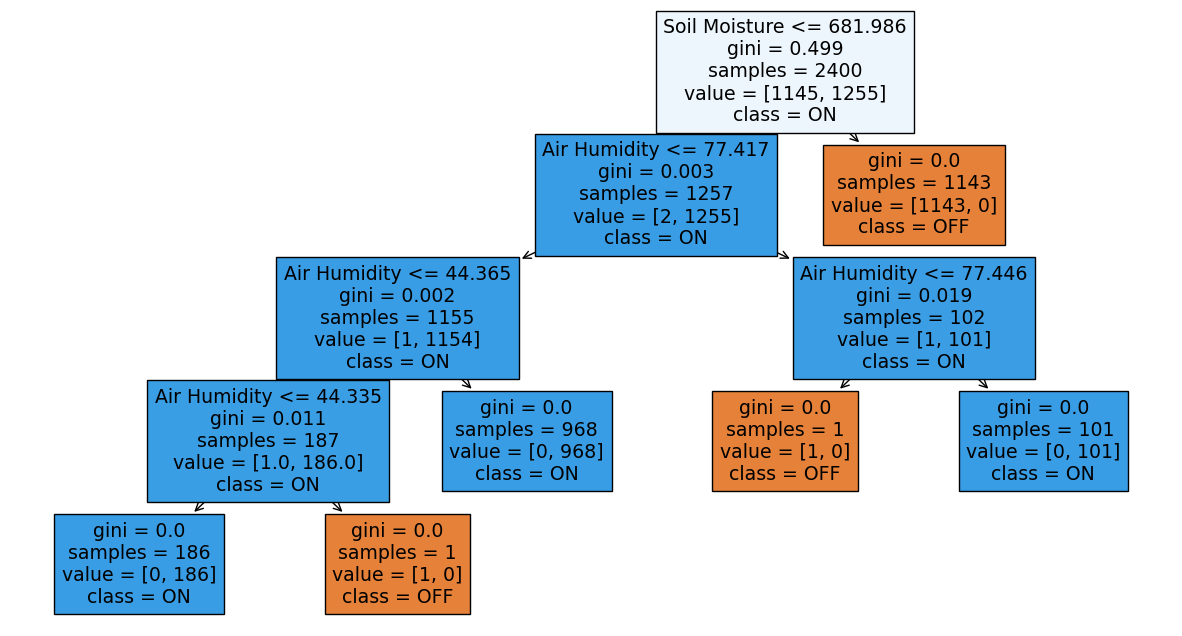

In [23]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=["OFF","ON"], filled=True)
plt.show()


In [24]:
# Irrigation Control Model Logger
import json
import datetime
import os

# Create logs directory if it doesn't exist
os.makedirs(f"{PROJECT_DIR}/logs/irrigation_control", exist_ok=True)

# Calculate training time
try:
    training_time_seconds = training_end_time - training_start_time
except NameError:
    # Fallback if timing wasn't captured
    training_time_seconds = 1.0  # Estimated time for decision tree

training_time_minutes = training_time_seconds / 60
training_time_hours = training_time_minutes / 60

# Get dataset information - convert to regular Python integers
train_class_distribution = {int(k): int(v) for k, v in y_train.value_counts().to_dict().items()}
test_class_distribution = {int(k): int(v) for k, v in y_test.value_counts().to_dict().items()}

# Get feature importance
feature_importance = dict(zip(X.columns, clf.feature_importances_))

# Prepare training log data
irrigation_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "model_type": "DecisionTreeClassifier",
    "hyperparameters": {
        "criterion": CRITERION,
        "splitter": "best",
        "max_depth": clf.max_depth,
        "min_samples_split": MAX_SAMPLE_SPLIT,
        "min_samples_leaf": MIN_SAMPLE_LEAF,
        "min_weight_fraction_leaf": 0.0,
        "max_features": clf.max_features,
        "random_state": clf.random_state,
        "max_leaf_nodes": clf.max_leaf_nodes,
        "min_impurity_decrease": 0.0,
        "class_weight": clf.class_weight
    },
    "dataset_info": {
        "data_file": "irrigation.csv",
        "features": list(X.columns),
        "target": "Pump Data",
        "total_samples": int(len(data)),
        "train_samples": int(len(X_train)),
        "test_samples": int(len(X_test)),
        "train_split": 0.8,
        "test_split": 0.2,
        "stratified": True,
        "random_state": 42,
        "train_class_distribution": train_class_distribution,
        "test_class_distribution": test_class_distribution
    },
    "training_time": {
        "total_seconds": float(training_time_seconds),
        "total_minutes": float(training_time_minutes),
        "total_hours": float(training_time_hours),
        "formatted": f"{int(training_time_hours):02d}h {int(training_time_minutes % 60):02d}m {int(training_time_seconds % 60):02d}s"
    },
    "results": {
        "accuracy": float(accuracy),
        "f1_score": float(f1),
        "precision": float(precision),
        "recall": float(recall),
        "tree_depth": int(clf.get_depth()),
        "n_leaves": int(clf.get_n_leaves()),
        "n_features": int(clf.n_features_in_),
        "feature_importance": {str(k): float(v) for k, v in feature_importance.items()}
    },
    "sample_predictions": {
        "sample_input": [700, 30, 65],  # Soil moisture, Temp, Humidity
        "sample_prediction": int(pred[0]),
        "sample_result": "Pump ON" if pred[0] == 1 else "Pump OFF"
    },
    "model_details": {
        "n_classes": int(len(clf.classes_)),
        "classes": [int(c) for c in clf.classes_],
        "class_names": ["Pump OFF", "Pump ON"]
    }
}

# Save to JSON file with timestamp
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"{PROJECT_DIR}/logs/irrigation_control/irrigation_log_{timestamp_str}.json"

with open(log_filename, 'w') as f:
    json.dump(irrigation_log, f, indent=2)

print(f"Irrigation control model log saved to: {log_filename}")

# Print summary
print("\n" + "="*60)
print("IRRIGATION CONTROL MODEL SUMMARY")
print("="*60)
print(f"Model: Decision Tree Classifier")
print(f"Training Time: {irrigation_log['training_time']['formatted']}")
print(f"Dataset: {irrigation_log['dataset_info']['total_samples']} samples")
print(f"Features: {', '.join(irrigation_log['dataset_info']['features'])}")
print(f"Test Accuracy: {irrigation_log['results']['accuracy']:.4f}")
print(f"F1 Score: {irrigation_log['results']['f1_score']:.4f}")
print(f"Precision: {irrigation_log['results']['precision']:.4f}")
print(f"Recall: {irrigation_log['results']['recall']:.4f}")
print(f"Tree Depth: {irrigation_log['results']['tree_depth']}")
print(f"Number of Leaves: {irrigation_log['results']['n_leaves']}")
print("\nFeature Importance:")
for feature, importance in feature_importance.items():
    print(f"  {feature}: {importance:.4f}")
print(f"\nCriterion: {CRITERION}")
print(f"Max Depth: {MAX_DEPTH if clf.max_depth else 'None'}")
print(f"Min Samples Split: {MAX_SAMPLE_SPLIT}")
print(f"Min Samples Leaf: {MIN_SAMPLE_LEAF}")
print("="*60)

Irrigation control model log saved to: ../logs/irrigation_control/irrigation_log_20250828_111954.json

IRRIGATION CONTROL MODEL SUMMARY
Model: Decision Tree Classifier
Training Time: 00h 00m 00s
Dataset: 3000 samples
Features: Soil Moisture, Temperature, Air Humidity
Test Accuracy: 0.9983
F1 Score: 0.9984
Precision: 1.0000
Recall: 0.9968
Tree Depth: 4
Number of Leaves: 6

Feature Importance:
  Soil Moisture: 0.9967
  Temperature: 0.0000
  Air Humidity: 0.0033

Criterion: gini
Max Depth: None
Min Samples Split: 2
Min Samples Leaf: 1
